In [94]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, log_loss, accuracy_score
import matplotlib
# from charset_normalizer import md__mypyc


In [95]:
%matplotlib inline

In [96]:
os.getcwd()

'/home/taehoon/cs565/modeling'

# Plotting PPG raw data

In [30]:
import glob
import pickle

In [31]:
WESAD_dir = './data/WESAD/'
pkl_files = glob.glob('./data/wrist-only/S*')

In [32]:
for file in pkl_files:
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='latin1')

In [33]:
data

{'signal': {'ACC': array([[-128.,  -55.,  127.],
         [-128.,   -3.,   85.],
         [  30.,   75.,   56.],
         ...,
         [  28.,   50.,   23.],
         [   3.,   60.,   39.],
         [ -26.,   29.,   50.]]),
  'BVP': array([[-10.02],
         [ -7.43],
         [ -4.57],
         ...,
         [ 29.07],
         [ 27.74],
         [ 25.88]]),
  'TEMP': array([[33.87],
         [33.87],
         [33.87],
         ...,
         [31.97],
         [31.97],
         [31.97]])},
 'label': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'subject': 'S9'}

<AxesSubplot: >

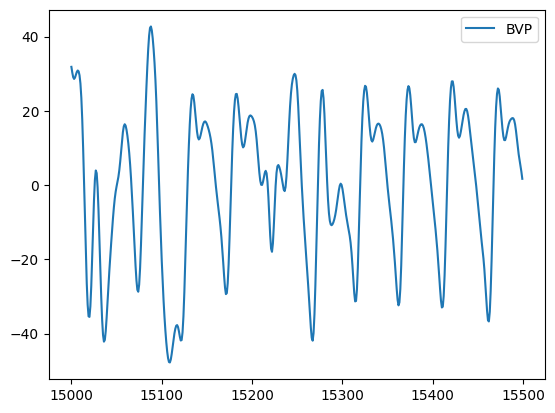

In [34]:
# pd.DataFrame({'BVP': data['signal']['BVP'].flatten(),
#               'label': data['label'].flatten()})
i = 15000
pd.DataFrame({'BVP': data['signal']['BVP'].flatten()}).iloc[i:i+500].plot()

### Merged_baseline

In [35]:
1000 / 64

15.625

In [146]:
condition = "stress"
f = open(f'/home/taehoon/cs565/modeling/data/arduino_ppg/{condition}_2.log', 'r')
# f = open('/home/taehoon/cs565/modeling/data/arduino_ppg/stress_2.log', 'r')


line = f.readlines()
f.close()
line = line[1:]
signal = []
for l in line:
    l = l.split('\n')[0]
    signal.append(l.split(','))

In [147]:
raw_data = pd.DataFrame({'timestamp': np.array(signal)[:, 0], 'BVP': np.array(signal)[:, 1], 'Temp': np.array(signal)[:, 2]}, dtype='float')

<AxesSubplot: >

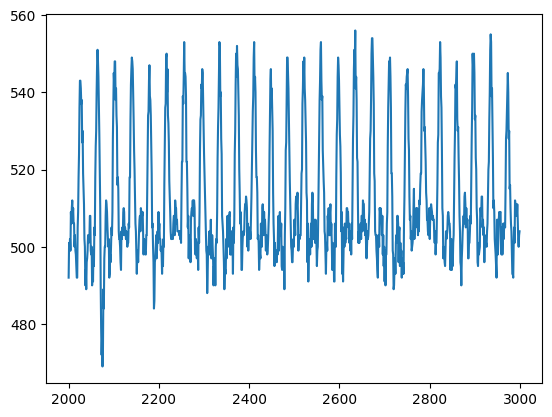

In [148]:
i = 2000
raw_data['BVP'].iloc[i:i+1000].plot()


In [149]:
hz = 1000/15
bucket_size = len(raw_data['BVP'])

In [150]:
from scipy import signal

[1.35240068e-12 2.75856476e-11 2.81202318e-10 ... 3.33667489e+01
 3.33661243e+01 3.33655005e+01]


<AxesSubplot: >

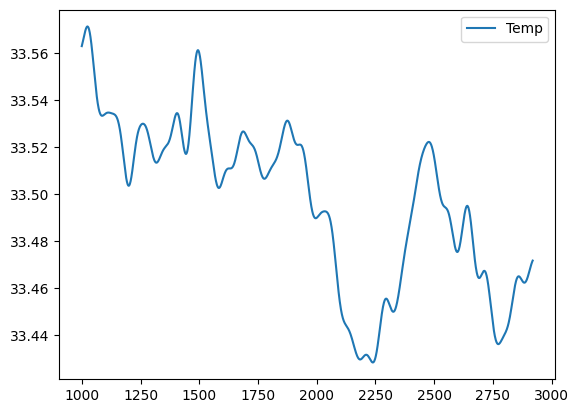

In [132]:
order = 10  # order
cut_off_freq = 0.7  # cut off frequency


bucket_size = len(raw_data)
bvp_sos = signal.butter(order, [cut_off_freq, 8], btype='band', fs=1000/15, output='sos')
bvp_filtered = signal.sosfilt(bvp_sos, raw_data["BVP"])


temp_sos = signal.butter(order, [1], btype='low', fs=1000/15, output='sos')
temp_filtered = signal.sosfilt(temp_sos, raw_data["Temp"].rolling(window=300).mean()[350:])
print(temp_filtered)
pd.DataFrame({'Temp': temp_filtered})[1000:1000+64*30].plot()

<AxesSubplot: >

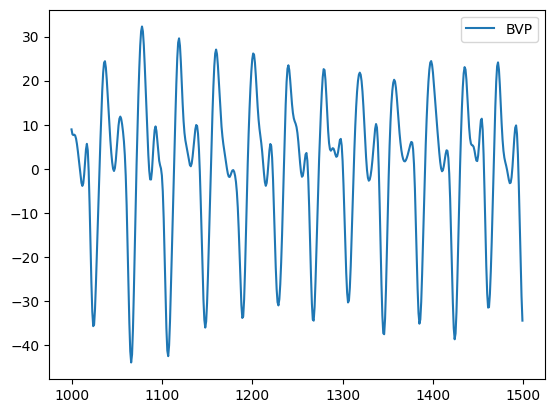

In [133]:
pd.DataFrame({'BVP': bvp_filtered})[1000:1500].plot()

# Feature Extraction

In [151]:
hz = {"BVP": 1000.0/15.0, "TEMP": 1000.0/15.0}
overlap_ratio = 0.9
window_size = 30

In [152]:
max_beat_per_sec = 200 / 60
min_sec_per_beat = 1 / max_beat_per_sec
dist = int(min_sec_per_beat * hz['BVP'])

In [153]:
wnd_ms = window_size * 1000
# raw_data = raw_data[1000:]

startT = raw_data['timestamp'].min()

endT = raw_data['timestamp'].max()

# find the end time of each window by considering the overlapping ratio 
WINDOWS = np.arange(startT + wnd_ms, endT, wnd_ms * (1 - overlap_ratio))
features = []
for sensor in ["BVP", "TEMP"]:
    feature_list = ["min", "max", "mean", "std"]
    if sensor == "BVP":
        feature_list = feature_list + ["peak_f"]
    for feature in feature_list:
        features.append(f"{sensor}_{feature}")
features.append("labels")

In [154]:
raw_data['BVP'].shape, raw_data['Temp'].shape

((19059,), (19059,))

In [155]:
FEATURES_TIME = pd.DataFrame(columns=features)
filtered_data = pd.DataFrame({"timestamp": raw_data['timestamp'], "BVP": raw_data['BVP'], "TEMP": raw_data['Temp']})
height = raw_data['BVP'].mean()

for w in WINDOWS:
    # for a given window, set the start and end time stamps 
    win_start, win_end = w - wnd_ms, w
    
    bucket_size = int(window_size * hz["BVP"])
    
    row = []
    data_wnd = filtered_data.loc[(filtered_data["timestamp"] > win_start) & (filtered_data["timestamp"] <= win_end)]
    bvp_sig_wnd, temp_sig_wnd = data_wnd['BVP'], data_wnd['TEMP']
    
    row.append(bvp_sig_wnd.min())
    row.append(bvp_sig_wnd.max())
    row.append(bvp_sig_wnd.mean())
    row.append(bvp_sig_wnd.std())
    
    # fft = np.fft.fft(bvp_sig_wnd * np.hamming(len(bvp_sig_wnd)), n=bucket_size)[1:bucket_size//2]
    # freq = np.fft.fftfreq(bucket_size, 1/hz[sensor])[1:bucket_size//2]
    # amp = np.abs(fft)
    # amp_norm = amp / bucket_size
    # energy = amp ** 2
    # energy_norm = energy / bucket_size

    # freq_max_amp = freq[np.argmax(amp_norm)]
    # weight_amp_avg = np.sum(amp * freq) / np.sum(amp)
    # weight_energy_avg = np.sum(energy * freq) / np.sum(energy)
    # power_entropy = - np.sum((energy / np.sum(energy)) * np.log(energy / np.sum(energy)))

    peaks = signal.find_peaks(bvp_sig_wnd, height=height, distance=dist)[0]
    n_peak = len(peaks) / window_size

    row.append(n_peak)
    # row.append(freq_max_amp)
    # row.append(weight_amp_avg)
    # row.append(weight_energy_avg)
    # row.append(power_entropy)

    row.append(temp_sig_wnd.min())
    row.append(temp_sig_wnd.max())
    row.append(temp_sig_wnd.mean())
    row.append(temp_sig_wnd.std())
    
    if condition == 'baseline':
        row.append(0) #baseline
    else:
        row.append(1) #stress

    FEATURES_TIME.loc[len(FEATURES_TIME)] = row

display(FEATURES_TIME)

,BVP_min,BVP_max,BVP_mean,BVP_std,BVP_peak_f,TEMP_min,TEMP_max,TEMP_mean,TEMP_std,labels
0,485.0,561.0,512.440446,16.848150,1.833333,30.62,36.42,33.554754,0.690338,1.0
1,469.0,561.0,512.216929,16.986857,1.800000,31.58,36.42,33.549579,0.685278,1.0
2,469.0,561.0,512.220476,17.036637,1.800000,31.58,36.09,33.528728,0.688757,1.0
3,469.0,561.0,512.209326,16.850773,1.800000,30.29,36.09,33.515205,0.696816,1.0
4,469.0,561.0,512.319818,16.937081,1.800000,30.29,38.03,33.512985,0.695611,1.0
...,...,...,...,...,...,...,...,...,...,...
82,470.0,564.0,511.933097,18.970367,1.766667,30.29,36.74,33.392235,0.686335,1.0
83,470.0,564.0,512.155094,18.767156,1.766667,30.29,36.74,33.395808,0.685584,1.0
84,470.0,564.0,512.362392,18.718854,1.766667,30.29,36.74,33.397755,0.684812,1.0
85,470.0,564.0,511.546883,18.639732,1.733333,30.29,36.74,33.399230,0.685126,1.0


In [156]:
FEATURES_TIME.to_csv(f"./data/processed/{condition}_raw_data.csv")
# FEATURES_TIME.to_csv("stress.csv")